# **IMPORTS**

In [51]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os
import gc
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import timm
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import seaborn as sns

# **DATASET LOADING**

In [3]:
training_images = "/kaggle/input/aiml-general-championship/KCDH2024_Training_Input_10K/KCDH2024_Training_Input_10K"
training_labels = "/kaggle/input/aiml-general-championship/KCDH2024_Training_GroundTruth.csv"

In [4]:
data = pd.read_csv(training_labels)
data.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0,1,0,0,0,0,0
1,ISIC_0024307,0,1,0,0,0,0,0
2,ISIC_0024308,0,1,0,0,0,0,0
3,ISIC_0024309,0,1,0,0,0,0,0
4,ISIC_0024310,1,0,0,0,0,0,0


In [36]:
train_paths = []
train_labels = []

for dirname, _, filenames in os.walk(training_images):
    for filename in filenames:
        for i in range(len(data)):
            if os.path.splitext(filename)[0] == data.iloc[i, 0]:
                for j in range(1, len(data.columns)):
                    if data.iloc[i, j] == 1:
                        train_paths.append(os.path.join(training_images, filename))
                        train_labels.append(j-1)

In [37]:
print(len(train_paths))
print(len(train_labels))

9600
9600


In [38]:
print(train_paths[0], train_labels[0])

/kaggle/input/aiml-general-championship/KCDH2024_Training_Input_10K/KCDH2024_Training_Input_10K/ISIC_0030912.jpg 1


In [39]:
train_data = pd.DataFrame({
    'path': train_paths,
    'label': train_labels
})
train_data.to_csv('train_data.csv', index=False)

print("Data saved to train_data.csv")

Data saved to train_data.csv


In [40]:
train_data.head()

,path,label
0,/kaggle/input/aiml-general-championship/KCDH20...,1
1,/kaggle/input/aiml-general-championship/KCDH20...,1
2,/kaggle/input/aiml-general-championship/KCDH20...,1
3,/kaggle/input/aiml-general-championship/KCDH20...,1
4,/kaggle/input/aiml-general-championship/KCDH20...,1


/tmp/ipykernel_33/2012260299.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.imshow(Image.open(train_data.iloc[0][0]))


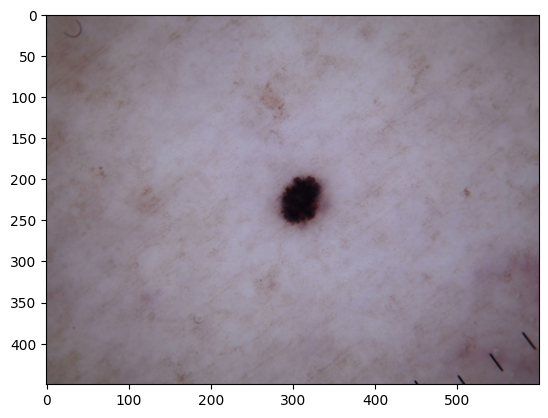

1


/tmp/ipykernel_33/2012260299.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(train_data.iloc[0][1])


In [44]:
plt.imshow(Image.open(train_data.iloc[0][0]))
plt.show()
print(train_data.iloc[0][1])

# **DATASET PRE-PROCESSING AND PREPARING FOR TRAINING**

In [3]:
data = pd.read_csv("/kaggle/input/lesiondataset/train_data.csv")

In [4]:
data.head()

,path,label
0,/kaggle/input/aiml-general-championship/KCDH20...,1
1,/kaggle/input/aiml-general-championship/KCDH20...,1
2,/kaggle/input/aiml-general-championship/KCDH20...,1
3,/kaggle/input/aiml-general-championship/KCDH20...,1
4,/kaggle/input/aiml-general-championship/KCDH20...,1


In [6]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)


train_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)

In [7]:
print(f"Training set size: {len(train_set)}")
print(f"Testing set size: {len(test_set)}")

Training set size: 7680
Testing set size: 1920


In [13]:
class LesionDataset(Dataset):
    
    def __init__(self, data, augmentations = None):
        self.data = data
        if augmentations is None:
          self.augmentations = transforms.Compose([transforms.ToTensor()])
        else:
            self.augmentations = augmentations
    
    def __getitem__(self, index):
        label = self.data.iloc[index][1]
        sample = Image.open(self.data.iloc[index][0])
        sample = self.augmentations(sample)
        
        return sample, label
    
    def __len__(self):
        return len(self.data)       

In [30]:
train_augmentations = transforms.Compose([
    transforms.Resize((250,250)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
test_augmentations = transforms.Compose([
    transforms.Resize((250,250)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [31]:
train_dataset = LesionDataset(train_set, train_augmentations)
test_dataset = LesionDataset(test_set, test_augmentations)

/tmp/ipykernel_34/3375622239.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = self.data.iloc[index][1]
/tmp/ipykernel_34/3375622239.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample = Image.open(self.data.iloc[index][0])


1


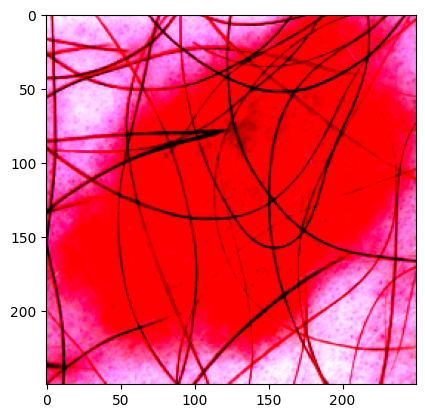

In [32]:
random_sample, random_label = train_dataset[5000]
random_sample = random_sample.permute(1, 2, 0)
plt.imshow(random_sample)
print(random_label)
plt.show()

In [35]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# **MODEL CREATION**

In [25]:
model = timm.create_model("xception", pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)

print(model)

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [44]:
device = "cpu"
model.to(device)

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

# **TRAINING**

In [45]:
class Config:
  learning_rate = 1e-4
  epochs = 10

In [46]:
class Trainer:
    def __init__(self, model, dataloaders, Config):
        self.model = model.to(device)
        self.train, self.test = dataloaders
        self.Config = Config
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.Config.learning_rate)
        self.loss_fn = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification

    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
        return (preds == labels).sum().item() / labels.shape[0]

    def train_one_epoch(self):
        running_loss = 0
        running_acc = 0

        for X, y in self.train:
            X = X.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.long)  # Ensure labels are long for CrossEntropyLoss

            self.optim.zero_grad()
            outputs = self.model(X)

            loss = self.loss_fn(outputs, y)
            loss.backward()
            self.optim.step()

            running_loss += loss.item()
            running_acc += self.accuracy(outputs, y)

            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()

        train_loss = running_loss / len(self.train)
        train_acc = running_acc / len(self.train)

        return train_loss, train_acc

    def fit(self):
        losses = []
        accuracies = []


        for epoch in range(self.Config.epochs):
            self.model.train()
            train_loss, train_acc = self.train_one_epoch()
            losses.append(train_loss)
            accuracies.append(train_acc)
            print(f"EPOCH {epoch+1}/{self.Config.epochs}")
            print(f"Training Loss: {train_loss} | Training Accuracy: {train_acc}\n\n")

    @torch.no_grad()
    def inference(self):
        self.model.eval()
        running_acc = 0

        for X, y in self.test:
            X = X.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.long)  # Ensure labels are long for CrossEntropyLoss
            outputs = self.model(X)
            running_acc += self.accuracy(outputs, y)

            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()

        accuracy = (running_acc / len(self.test)) * 100
        return accuracy

    def predict(self, input_image):
        self.model.eval()
        input_image = input_image.to(device, dtype=torch.float)
        output = self.model(input_image)

        _, predicted_class = torch.max(output, 1)  # Get the index of the max log-probability
        return predicted_class.item()

In [47]:
torch.cuda.set_per_process_memory_fraction(0.5, device=None)

In [48]:
trainer = Trainer(model, (train_dataloader, test_dataloader), Config)
trainer.fit()

/tmp/ipykernel_34/3375622239.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = self.data.iloc[index][1]
/tmp/ipykernel_34/3375622239.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample = Image.open(self.data.iloc[index][0])
/tmp/ipykernel_34/3375622239.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = self.data.iloc[index][1]
/tmp/ipykernel_34/3375622239.py:12: FutureWarning: Series.__getitem__ treating

EPOCH 1/10
Training Loss: 0.6984307706045608 | Training Accuracy: 0.764453125




/tmp/ipykernel_34/3375622239.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = self.data.iloc[index][1]
/tmp/ipykernel_34/3375622239.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample = Image.open(self.data.iloc[index][0])
/tmp/ipykernel_34/3375622239.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = self.data.iloc[index][1]
/tmp/ipykernel_34/3375622239.py:12: FutureWarning: Series.__getitem__ treating

EPOCH 2/10
Training Loss: 0.3240650555351749 | Training Accuracy: 0.8864583333333333




/tmp/ipykernel_34/3375622239.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = self.data.iloc[index][1]
/tmp/ipykernel_34/3375622239.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample = Image.open(self.data.iloc[index][0])
/tmp/ipykernel_34/3375622239.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = self.data.iloc[index][1]
/tmp/ipykernel_34/3375622239.py:12: FutureWarning: Series.__getitem__ treating

EPOCH 3/10
Training Loss: 0.12718455034773796 | Training Accuracy: 0.9595052083333333




/tmp/ipykernel_34/3375622239.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = self.data.iloc[index][1]
/tmp/ipykernel_34/3375622239.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample = Image.open(self.data.iloc[index][0])
/tmp/ipykernel_34/3375622239.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = self.data.iloc[index][1]
/tmp/ipykernel_34/3375622239.py:12: FutureWarning: Series.__getitem__ treating

KeyboardInterrupt: 

In [49]:
torch.save(model.state_dict(), 'lesionModel.pth')
print("Model saved successfully!!")

Model saved successfully!!


# **EVALUATION**

In [52]:
@torch.no_grad()
def calculate_test_metrics(model, test_loader, device, classes):
    model.eval()
    y_true = []
    y_pred = []
    y_pred_proba = []

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_pred_proba.append(torch.softmax(outputs, dim=1).cpu().numpy())  # Append instead of extend

        del inputs, labels
        torch.cuda.empty_cache()

    y_pred_proba = np.concatenate(y_pred_proba, axis=0)  # Convert list of arrays to a single numpy array

    print("Classification Report:")
    print(classification_report(y_true, np.argmax(y_pred_proba, axis=1), target_names=classes))

    print("Confusion Matrix:")
    plot_confusion_matrix(y_true, np.argmax(y_pred_proba, axis=1), classes)

    print("ROC Curve:")
    plot_roc_curve(y_true, y_pred_proba, len(classes))

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, n_classes):
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Convert y_true to binary matrix
    y_true_binary = np.eye(n_classes)[y_true]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [53]:
@torch.no_grad()
def calculate_test_accuracy(model, test_loader, device):
    model.eval()
    running_corrects = 0
    total_samples = 0

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels)
        total_samples += labels.size(0)

        del inputs
        del labels
        gc.collect()
        torch.cuda.empty_cache()

    test_accuracy = running_corrects / total_samples
    return test_accuracy.item()

In [54]:
model.load_state_dict(torch.load('lesionModel.pth'))
model.eval()

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [57]:
test_accuracy = calculate_test_accuracy(model, test_dataloader, device)
print(f"Test Accuracy: {test_accuracy}")

/tmp/ipykernel_34/3375622239.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = self.data.iloc[index][1]
/tmp/ipykernel_34/3375622239.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample = Image.open(self.data.iloc[index][0])
/tmp/ipykernel_34/3375622239.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = self.data.iloc[index][1]
/tmp/ipykernel_34/3375622239.py:12: FutureWarning: Series.__getitem__ treating

Test Accuracy: 0.8734375238418579


In [58]:
label_mapping = {'MEL':0, 'NV':1, 'BCC':2, 'AKIEC':3, 'BKL':4, 'DF':5, 'VASC':6}

# Extract class labels from the keys of label_mapping
classes = list(label_mapping.keys())

print(classes)  # Just to verify the classes

['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']


/tmp/ipykernel_34/3375622239.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = self.data.iloc[index][1]
/tmp/ipykernel_34/3375622239.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample = Image.open(self.data.iloc[index][0])
/tmp/ipykernel_34/3375622239.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = self.data.iloc[index][1]
/tmp/ipykernel_34/3375622239.py:12: FutureWarning: Series.__getitem__ treating

Classification Report:
              precision    recall  f1-score   support

         MEL       0.70      0.62      0.66       210
          NV       0.92      0.96      0.94      1281
         BCC       0.76      0.86      0.80        98
       AKIEC       0.68      0.73      0.71        64
         BKL       0.88      0.64      0.74       214
          DF       0.94      0.70      0.80        23
        VASC       0.81      0.87      0.84        30

    accuracy                           0.87      1920
   macro avg       0.81      0.77      0.78      1920
weighted avg       0.87      0.87      0.87      1920

Confusion Matrix:


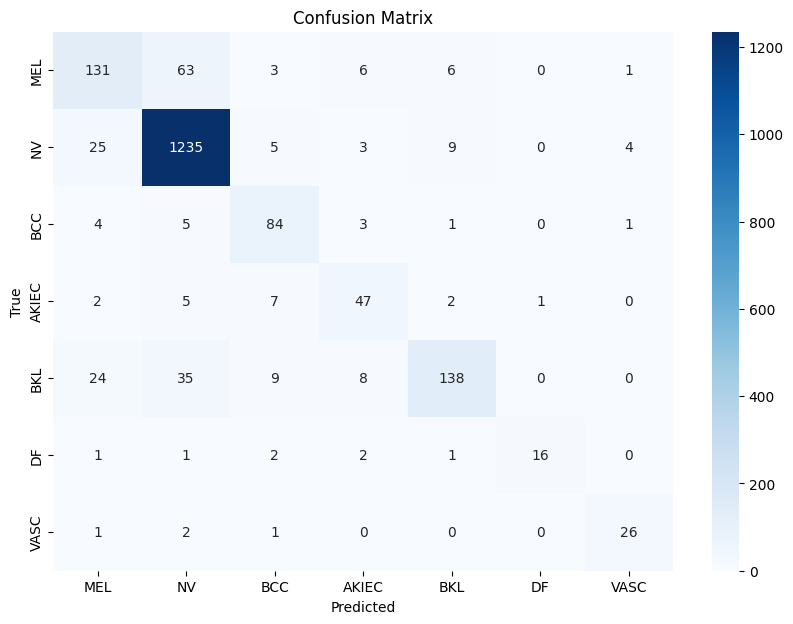

ROC Curve:


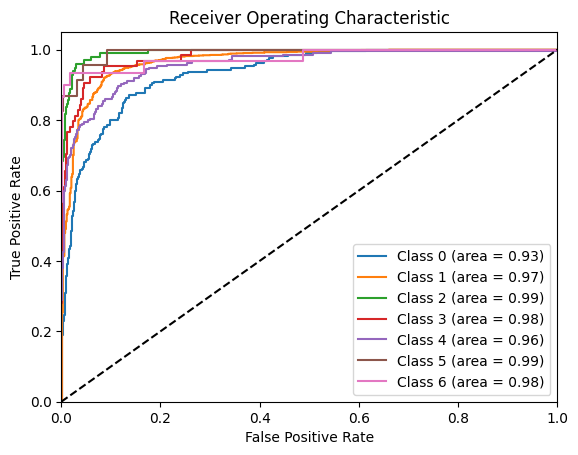

In [59]:
calculate_test_metrics(model, test_dataloader, device, classes)

# **TESTING**

In [61]:
testing_dir = "/kaggle/input/aiml-general-championship/KCDH2024_Test_Input/KCDH2024_Test_Input"
test_paths = []
predictions = []

transform = transforms.Compose([
    transforms.Resize((250,250)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

for dirname, _, filenames in os.walk(testing_dir):
    for filename in filenames:
        if filename.endswith('.jpg'):
            sample = os.path.join(testing_dir, filename)
            image = Image.open(sample)
            input_data = transform(image).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(input_data)
            probabilities = torch.softmax(output, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
            test_paths.append(os.path.splitext(filename)[0])
            predictions.append(predicted_class)

In [63]:
test_results = pd.DataFrame({
    'ID': test_paths,
    'Class': predictions
})
test_results.to_csv('testingresult.csv', index=False)

print("Data saved to testingresult.csv")

Data saved to testingresult.csv


In [64]:
test_results.head()

,ID,Class
0,ISIC_0035342,1
1,ISIC_0035050,0
2,ISIC_0034851,1
3,ISIC_0034920,1
4,ISIC_0035278,1
